In [1]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
from sklearn.model_selection import KFold

%matplotlib inline

Using TensorFlow backend.


In [2]:
#data = quandl.get('BCHARTS/BITFINEXUSD') -> OLD BUGGY DATASET (OBD)
#data = quandl.get('BITFINEX/BTCUSD')
#data = quandl.get('BITFINEX/XRPBTC')
data = quandl.get('BITFINEX/ETHBTC')

In [3]:
data.head()

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2016-03-14,0.050580,0.028241,0.031181,0.031103,0.031102,0.031260,111142.045174
2016-03-15,0.032004,0.027950,0.031298,0.031399,0.031207,0.031390,62965.262239
2016-03-16,0.033500,0.030465,0.030700,0.030690,0.030690,0.030709,55947.825399
2016-03-17,0.030989,0.024759,0.026878,0.026816,0.026821,0.026935,94445.983815
2016-03-18,0.026960,0.020150,0.026555,0.026509,0.026506,0.026605,141106.891752


In [4]:
print("data shape before embedding:",data.shape)

mean = data.mean(axis=0)
std = data.std(axis=0)

# zscore normalization
data = ( data - mean ) / std

# # of days past we want skynet to see
d = 7

X = np.zeros((data.shape[0],d,data.shape[1]))

# embedding d days in each DP (deslocamento)
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#removing first d lines, this ones didn't have d days past
X = X[d:,:,:]

print("data shape after embedding:",X.shape)

data shape before embedding: (653, 7)
data shape after embedding: (646, 7, 7)


In [5]:
# creating labels
Y = data['Mid'] - data.shift(1)['Mid']

Y = Y > 0

Y.shape

(653,)

In [6]:
#removing first line: second label refers to first DP ($$ delta)
Y = Y[1:]

#removing first d days because of the embedding
Y = Y[d:]

In [7]:
#removing last registry from X, since we had to remove first DP from Y
#specifying other dimensions for good practices - TY @lucasosouza
X = X[: -1,:,:]

In [8]:
# checking shapes
Y.shape, X.shape

((645,), (645, 7, 7))

In [9]:
# Adding channel layer, as expected by the convnet
X = X.reshape((Y.shape[0],d,7,1))
X.shape

(645, 7, 7, 1)

In [10]:
# train / test split
#X_train = X[:-300,:,:,:]
#X_test = X[-300:,:,:,:]
#Y_train = Y[:-300]
#Y_test = Y[-300:]

# split dat data 
kf = KFold(n_splits=8,shuffle=True,random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #print("TRAIN:", train_index, "TEST:", test_index)

In [11]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same so we dont lose size
    X = Conv2D(32,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    #X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(64,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    #X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    X = Conv2D(128,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn2')(X)
    X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(128,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(64,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(32,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [12]:
#training the model, time for witchcraft
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 200, batch_size = 8,verbose=1)

Epoch 1/200
565/565 [==============================] - 2s 4ms/step - loss: 0.8151 - acc: 0.4655
Epoch 2/200
565/565 [==============================] - 2s 4ms/step - loss: 0.7043 - acc: 0.5434
Epoch 3/200
565/565 [==============================] - 2s 4ms/step - loss: 0.6994 - acc: 0.5239
Epoch 4/200
565/565 [==============================] - 2s 4ms/step - loss: 0.6784 - acc: 0.5752
Epoch 5/200
565/565 [==============================] - 2s 4ms/step - loss: 0.6863 - acc: 0.5858
Epoch 6/200
565/565 [==============================] - 2s 4ms/step - loss: 0.6734 - acc: 0.6088
Epoch 7/200
565/565 [==============================] - 2s 4ms/step - loss: 0.6876 - acc: 0.5487
Epoch 8/200
565/565 [==============================] - 2s 4ms/step - loss: 0.6650 - acc: 0.5788
Epoch 9/200
565/565 [==============================] - 2s 4ms/step - loss: 0.6637 - acc: 0.5858
Epoch 10/200
565/565 [==============================] - 2s 4ms/step - loss: 0.6487 - acc: 0.6124
Epoch 11/200
565/565 [=================

565/565 [==============================] - 3s 5ms/step - loss: 0.1218 - acc: 0.9469
Epoch 86/200
565/565 [==============================] - 3s 5ms/step - loss: 0.1203 - acc: 0.9469
Epoch 87/200
565/565 [==============================] - 2s 4ms/step - loss: 0.1898 - acc: 0.9150
Epoch 88/200
565/565 [==============================] - 2s 4ms/step - loss: 0.1214 - acc: 0.9451
Epoch 89/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0962 - acc: 0.9593
Epoch 90/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0954 - acc: 0.9575
Epoch 91/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0671 - acc: 0.9699
Epoch 92/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0584 - acc: 0.9752
Epoch 93/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0411 - acc: 0.9805
Epoch 94/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0548 - acc: 0.9841
Epoch 95/200
565/565 [=====================

565/565 [==============================] - 3s 5ms/step - loss: 0.0015 - acc: 1.0000
Epoch 169/200
565/565 [==============================] - 3s 5ms/step - loss: 0.0011 - acc: 1.0000
Epoch 170/200
565/565 [==============================] - 3s 5ms/step - loss: 5.2885e-04 - acc: 1.0000
Epoch 171/200
565/565 [==============================] - 2s 4ms/step - loss: 7.5410e-04 - acc: 1.0000
Epoch 172/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0018 - acc: 1.0000
Epoch 173/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0765 - acc: 0.9841
Epoch 174/200
565/565 [==============================] - 2s 4ms/step - loss: 0.3814 - acc: 0.8903
Epoch 175/200
565/565 [==============================] - 2s 4ms/step - loss: 0.1932 - acc: 0.9239
Epoch 176/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0738 - acc: 0.9752
Epoch 177/200
565/565 [==============================] - 2s 4ms/step - loss: 0.0357 - acc: 0.9929
Epoch 178/200
565/565 [===

In [16]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

80/80 [==============================] - 0s 763us/step

Loss = 4.02511167526
Acc = 0.5


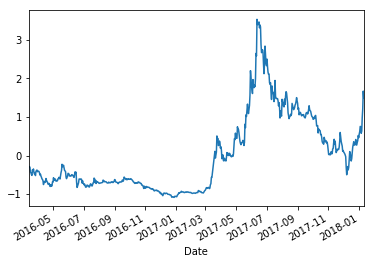

In [14]:
data['Mid'].plot()
